In [1]:
import numpy as np
import torch
from torch import nn
import gym
import cv2
import copy
import time
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns

%matplotlib inline

In [2]:
env = gym.make('BreakoutDeterministic-v4')
# env = gym.make('SpaceInvadersDeterministic-v4')
print('Action space:', env.action_space)
print('Observation space:', env.observation_space)

Action space: Discrete(4)
Observation space: Box(210, 160, 3)


In [3]:
N_FRAMES = 4

def filter_obs(obs, resize_shape=(84, 110), crop_shape=None):
    assert(type(obs) == np.ndarray), "The observation must be a numpy array!"
    assert(len(obs.shape) == 3), "The observation must be a 3D array!"

    obs = cv2.resize(obs, resize_shape, interpolation=cv2.INTER_LINEAR)
    obs = cv2.cvtColor(obs, cv2.COLOR_BGR2GRAY)
    obs = obs / 255.
    if crop_shape:
        crop_x_margin = (resize_shape[1] - crop_shape[1]) // 2
        crop_y_margin = (resize_shape[0] - crop_shape[0]) // 2
        
        x_start, x_end = crop_x_margin, resize_shape[1] - crop_x_margin
        y_start, y_end = crop_y_margin, resize_shape[0] - crop_y_margin
        
        obs = obs[x_start:x_end, y_start:y_end]
    
    return obs

def get_stacked_obs(obs, prev_frames):
    if not prev_frames:
        prev_frames = [obs] * (N_FRAMES - 1)
        
    prev_frames.append(obs)
    stacked_frames = np.stack(prev_frames)
    prev_frames = prev_frames[-(N_FRAMES-1):]
    
    return stacked_frames, prev_frames

def preprocess_obs(obs, prev_frames):
    filtered_obs = filter_obs(obs)
    stacked_obs, prev_frames = get_stacked_obs(filtered_obs, prev_frames)
    return stacked_obs, prev_frames

def format_reward(reward):
    if reward > 0:
        return 1
    elif reward < 0:
        return -1
    return 0

In [4]:
# Original Paper
class DQN(nn.Module):
    def __init__(self, n_acts):
        super(DQN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(N_FRAMES, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU())

        self.value_layer1 = nn.Sequential(
            nn.Linear(64 * 10 * 7, 512),
            nn.ReLU())
        self.value_layer2 = nn.Linear(512, 1)

        self.advantages_layer1 = nn.Sequential(
            nn.Linear(64 * 10 * 7, 512),
            nn.ReLU())
        self.advantages_layer2 = nn.Linear(512, n_acts)
        
    def forward(self, obs):
        z = self.layer1(obs)
        z = self.layer2(z)
        z = self.layer3(z)
        z = z.view(-1, 64 * 10 * 7)
        
        values = self.value_layer1(z)
        values = self.value_layer2(values)
        
        advantages = self.advantages_layer1(z)
        advantages = self.advantages_layer2(advantages)
        
        advantage_means = torch.mean(advantages, dim=1)
        advantages = advantages - advantage_means.view(-1, 1)
        
        qs = values + advantages
        
        return qs

    def train_on_batch(self, target_model, optimizer, obs, acts, rewards, next_obs, terminals, gamma=0.99):
        next_q_values = self.forward(next_obs)
        max_next_acts = torch.max(next_q_values, dim=1)[1].detach()
        
        target_next_q_values = target_model.forward(next_obs)
        max_next_q_values = target_next_q_values.gather(index=max_next_acts.view(-1, 1), dim=1)
        max_next_q_values = max_next_q_values.view(-1).detach()
        
        terminal_mods = 1 - terminals
        actual_qs = rewards + terminal_mods * gamma * max_next_q_values
            
        pred_qs = self.forward(obs)
        pred_qs = pred_qs.gather(index=acts.view(-1, 1), dim=1).view(-1)
        
        loss = torch.mean((actual_qs - pred_qs) ** 2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [5]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity = capacity
        self.data = []
        
    def add_step(self, step_data):
        self.data.append(step_data)
        if len(self.data) > self.capacity:
            self.data = self.data[-self.capacity:]
            
    def sample(self, n):
        n = min(n, len(self.data))
        indices = np.random.choice(range(len(self.data)), n, replace=False)
        samples = np.asarray(self.data)[indices]
        
        state_data = torch.tensor(np.stack(samples[:, 0])).float().cuda()
        act_data = torch.tensor(np.stack(samples[:, 1])).long().cuda()
        reward_data = torch.tensor(np.stack(samples[:, 2])).float().cuda()
        next_state_data = torch.tensor(np.stack(samples[:, 3])).float().cuda()
        terminal_data = torch.tensor(np.stack(samples[:, 4])).float().cuda()
        
        return state_data, act_data, reward_data, next_state_data, terminal_data

In [6]:
n_episodes = 100000
max_steps = 1000
er_capacity = 100000 # 1m in paper
n_acts = env.action_space.n
train_batch_size = 32
learning_rate = 2.5e-4
update_freq = 4
print_freq = 100
frame_skip = 3
n_anneal_steps = 1e5 # Anneal over 1m steps in paper
target_update_delay = 10000 # How many episodes in between target model update
epsilon = lambda step: np.clip(1 - 0.9 * (step/n_anneal_steps), 0.1, 1) # Anneal over 1m steps in paper, 100k here
n_step = 4
gamma = 0.99

In [7]:
er = ExperienceReplay(er_capacity)
model = DQN(n_acts=env.action_space.n).cuda()
target_model = copy.deepcopy(model)
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, eps=1e-6)
all_rewards = []
global_step = 0

for episode in range(n_episodes):
    n_step_rewards = []
    n_step_states = []
    n_step_actions = []
    prev_frames = []
    obs, prev_frames = preprocess_obs(env.reset(), prev_frames)
    n_step_states.append(obs)
    
    episode_reward = 0
    step = 0
    while step < max_steps:

        ### Enact a step ###
        
        if np.random.rand() < epsilon(global_step):
            act = np.random.choice(range(n_acts))
        else:
            obs_tensor = torch.tensor([obs]).float().cuda()
            q_values = model(obs_tensor)[0]
            q_values = q_values.cpu().detach().numpy()
            act = np.argmax(q_values)
        
        cumulative_reward = 0
        for _ in range(frame_skip):
            next_obs, reward, done, _ = env.step(act)
            cumulative_reward += reward
            if done or step >= max_steps:
                break
        episode_reward += cumulative_reward
        reward = format_reward(cumulative_reward)

        next_obs, prev_frames = preprocess_obs(next_obs, prev_frames)

        ### N-step Calculations ###
    
        n_step_rewards.append(reward)
        n_step_rewards = n_step_rewards[-n_step:]
        n_step_actions.append(act)
        n_step_actions = n_step_actions[-n_step:]
        
        if len(n_step_rewards) == n_step and len(n_step_states) == n_step and \
           len(n_step_actions) == n_step:
            ns_obs = n_step_states[0]
            ns_act = n_step_actions[0]
            ns_reward = sum([reward * gamma ** i for i, reward in enumerate(n_step_rewards)])
            ns_next_obs = next_obs
            ns_done = int(done)
        
            er.add_step([ns_obs, ns_act, ns_reward, ns_next_obs, ns_done])
            
        n_step_states.append(next_obs)
        n_step_states = n_step_states[-n_step:]
        
        obs = next_obs
        
        ### Train on a minibatch ###
        
        if global_step % update_freq == 0 and len(er.data) > train_batch_size:
            obs_data, act_data, reward_data, next_obs_data, terminal_data = er.sample(train_batch_size)
            model.train_on_batch(target_model, optimizer, obs_data, act_data,
                                 reward_data, next_obs_data, terminal_data)
        
        ### Update target network ###
        
        if global_step and global_step % target_update_delay == 0:
            target_model = copy.deepcopy(model)
        
        ### Finish the step ###
        
        step += 1
        global_step += 1
        
        if done:
            break

    if len(n_step_rewards) == n_step and len(n_step_states) == n_step and \
       len(n_step_actions) == n_step:
        for i in range(1, n_step):
            ns_obs = n_step_states[i-1]
            ns_act = n_step_actions[i]
            ns_reward = sum([reward * gamma ** i for i, reward in enumerate(n_step_rewards[i:])])
            ns_next_obs = next_obs
            ns_done = 1
            
            er.add_step([ns_obs, ns_act, ns_reward, ns_next_obs, ns_done])
            
    all_rewards.append(episode_reward)
    
    if episode % print_freq == 0:
        print('Episode #{} | Step #{} | Epsilon {:.2f} | Avg. Reward {:.2f}'.format(
            episode, global_step, epsilon(global_step), np.mean(all_rewards[-print_freq:])))

Episode #0 | Step #74 | Epsilon 1.00 | Avg. Reward 2.00
Episode #100 | Step #7508 | Epsilon 0.93 | Avg. Reward 1.63
Episode #200 | Step #14929 | Epsilon 0.87 | Avg. Reward 1.50
Episode #300 | Step #22897 | Epsilon 0.79 | Avg. Reward 2.21
Episode #400 | Step #30906 | Epsilon 0.72 | Avg. Reward 2.88
Episode #500 | Step #39587 | Epsilon 0.64 | Avg. Reward 3.72
Episode #600 | Step #50038 | Epsilon 0.55 | Avg. Reward 5.49
Episode #700 | Step #61304 | Epsilon 0.45 | Avg. Reward 7.17
Episode #800 | Step #74235 | Epsilon 0.33 | Avg. Reward 8.99
Episode #900 | Step #88175 | Epsilon 0.21 | Avg. Reward 10.03
Episode #1000 | Step #105590 | Epsilon 0.10 | Avg. Reward 16.74
Episode #1100 | Step #124976 | Epsilon 0.10 | Avg. Reward 17.95
Episode #1200 | Step #144454 | Epsilon 0.10 | Avg. Reward 18.47
Episode #1300 | Step #163372 | Epsilon 0.10 | Avg. Reward 18.20
Episode #1400 | Step #183653 | Epsilon 0.10 | Avg. Reward 21.62
Episode #1500 | Step #204059 | Epsilon 0.10 | Avg. Reward 21.45
Episode #16

KeyboardInterrupt: 

In [8]:
# Episode #0 | Step #75 | Epsilon 1.00 | Avg. Reward 1.00
# Episode #100 | Step #6985 | Epsilon 0.94 | Avg. Reward 1.11
# Episode #200 | Step #14440 | Epsilon 0.87 | Avg. Reward 1.55
# Episode #300 | Step #22300 | Epsilon 0.80 | Avg. Reward 2.16
# Episode #400 | Step #29814 | Epsilon 0.73 | Avg. Reward 2.43
# Episode #500 | Step #38500 | Epsilon 0.65 | Avg. Reward 3.50
# Episode #600 | Step #48150 | Epsilon 0.57 | Avg. Reward 4.79
# Episode #700 | Step #58476 | Epsilon 0.47 | Avg. Reward 5.28
# Episode #800 | Step #70518 | Epsilon 0.37 | Avg. Reward 7.62
# Episode #900 | Step #83728 | Epsilon 0.25 | Avg. Reward 9.20
# Episode #1000 | Step #99126 | Epsilon 0.11 | Avg. Reward 12.72

In [16]:
prev_frames = []
obs, prev_frames = preprocess_obs(env.reset(), prev_frames)

for step in range(max_steps):
    if np.random.rand() < 0.00:
        act = np.random.choice(range(n_acts))
    else:
        obs_tensor = torch.tensor([obs]).float().cuda()
        q_values = model(obs_tensor)[0]
        q_values = q_values.cpu().detach().numpy()
        act = np.argmax(q_values)

    for _ in range(frame_skip):
        next_obs, reward, done, _ = env.step(act)
        if done or step >= max_steps:
            break
            
        env.render()
        time.sleep(0.05)
        
    if done:
        break

    obs, prev_frames = preprocess_obs(next_obs, prev_frames)

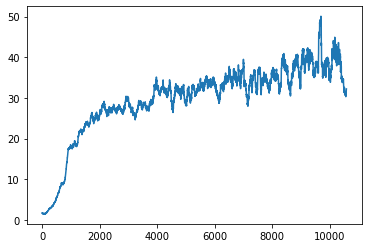

In [12]:
smoothed_rewards = []
smooth_window = 50
for i in range(smooth_window, len(all_rewards)-smooth_window):
    smoothed_rewards.append(np.mean(all_rewards[i-smooth_window:i+smooth_window]))
    
plt.plot(range(len(smoothed_rewards)), smoothed_rewards)

In [14]:
torch.save(model, 'models/nstep_dddqn_breakout_r40.pt')